<br>
<br>
<center>
    
# 人工智能高阶人才培训班

<br>

> ## 如何构建一个人工智能项目(二)
</center>
<br>

<img src='../static/img/logo.jpg' align='right' style="width:260px;height:80 px"/>


# 猫🐱-狗🐕分类问题


![](img/cat-dog.jpeg)

> 背景：Kaggle比赛，25，000张训练图像,通过使用深度学习算法，kaggle上目前取得了98%的准确率，我们仅使用8%的数据集，一起来看下效果

在本次实验中，我们一起探讨如何通过迁移学习方法利用预训练模型实现猫狗分类问题，只利用很少的一部分数据集取得不错的效果。

在本次实验中，我们将紧接上次实验的内容，继续进行模型训练与优化。

In [1]:
import os
import random

import tensorflow as tf
from tensorflow import keras
print("TensorFlow version is ", tf.__version__)

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

TensorFlow version is  2.4.1


## 0. 问题定义

> 猫狗分类实质上是一个二分类问题，输入的是图像数据，输出的是分类的结果

## 1. 数据导入及数据理解

In [2]:
zip_file = tf.keras.utils.get_file(origin="https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip",
                                   fname="cats_and_dogs_filtered.zip", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [3]:
base_dir

'/home/jovyan/.keras/datasets/cats_and_dogs_filtered'

In [4]:
# 创建 test 文件夹
os.system("cd /home/jovyan/.keras/datasets/cats_and_dogs_filtered && mkdir test")
# 创建 test/cats/ & test/dogs 文件夹
os.system("mkdir /home/jovyan/.keras/datasets/cats_and_dogs_filtered/test/dogs && mkdir /home/jovyan/.keras/datasets/cats_and_dogs_filtered/test/cats")

256

### 准备训练数据和验证数据


In [5]:
cats_action_list = os.listdir(os.path.join(base_dir, 'train/cats'))
dogs_action_list = os.listdir(os.path.join(base_dir, 'train/dogs'))

for name in cats_action_list:
    imageNum = int(name.split('.')[1])
    # 从 train 的 cats/ 中各拿出 100 个图片放入 test/ 中对应文件夹
    if imageNum >= 900:
        os.system("mv /home/jovyan/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog." + str(imageNum) + ".jpg /home/jovyan/.keras/datasets/cats_and_dogs_filtered/test/dogs")        
        os.system("mv /home/jovyan/.keras/datasets/cats_and_dogs_filtered/train/cats/cat." + str(imageNum) + ".jpg /home/jovyan/.keras/datasets/cats_and_dogs_filtered/test/cats")
        
for name in dogs_action_list:
    imageNum = int(name.split('.')[1])
    # 从 train 的 dogs/ 中各拿出 100 个图片放入 test/ 中对应文件夹
    if imageNum >= 900:
        os.system("mv /home/jovyan/.keras/datasets/cats_and_dogs_filtered/train/dogs/dog." + str(imageNum) + ".jpg /home/jovyan/.keras/datasets/cats_and_dogs_filtered/test/dogs")

In [6]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
print ('Total training cat images:', len(os.listdir(train_cats_dir)))

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
print ('Total validation cat images:', len(os.listdir(validation_cats_dir)))

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
print ('Total validation dog images:', len(os.listdir(validation_dogs_dir)))

# Directory with our training cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
print ('Total training cat images:', len(os.listdir(test_cats_dir)))

# Directory with our training dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
print ('Total training dog images:', len(os.listdir(test_dogs_dir)))

Total training cat images: 900
Total training dog images: 900
Total validation cat images: 500
Total validation dog images: 500
Total training cat images: 100
Total training dog images: 100


> 训练样本很平衡

### 创建数据生成器

In [7]:
image_size = 160 # All images will be resized to 160x160
batch_size = 128

In [8]:
IMG_SHAPE = (image_size, image_size, 3)

# 模型优化及上线
作为第二次课的实验部分，我们一起研究下如何对上述模型进行优化，并部署上线

## 数据增强
[`keras.preprocessing.image.ImageDataGenerator`](https://keras.io/zh/preprocessing/image/)


- 在训练期间在您的图像数据上配置随机变换和规范化操作
- 通过.flow（data, labels）或.flow_from_directory（directory）实例化被数据增强的image batches（及其标签）的生成器。这些生成器可以用于fit_generator，evaluate_generator和predict_generator这些接受数据生成器作为输入的keras模型方法。

### 举例

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

- rotation_range是一个角度值(0-180)，代表随机旋转图像的范围。
- width_shift和height_shift是随机水平或垂直的平移图片的范围（占总宽或高的比例）
- rescale是是我们在其他任何处理之前乘以数据的一个值。我们的原始图像是包含在0-255的RGB像素，但是对于我们的模型来说，这样的数值太高了（给定一个典型的学习速率），所以我们通过一个1./255的缩放因子将目标值设定在0和1之间。
- shear_range用于shearing变换（大致含义是将图形的垂直边（水平边）沿水平（垂直）方向倾斜）
- zoom_range用于在图像中进行随机的缩放
- horizontal_flip 用于随机的水平翻转图像
- fill_mode是用于填充空白的策略，在旋转或宽度/高度平移后会出现

In [10]:
if os.path.exists("preview") is False:
    os.mkdir("preview")

In [11]:
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

cat_sample = os.path.join(train_dir, 'cats/cat.1.jpg')
img = load_img(cat_sample)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [12]:
samples = os.listdir("preview")

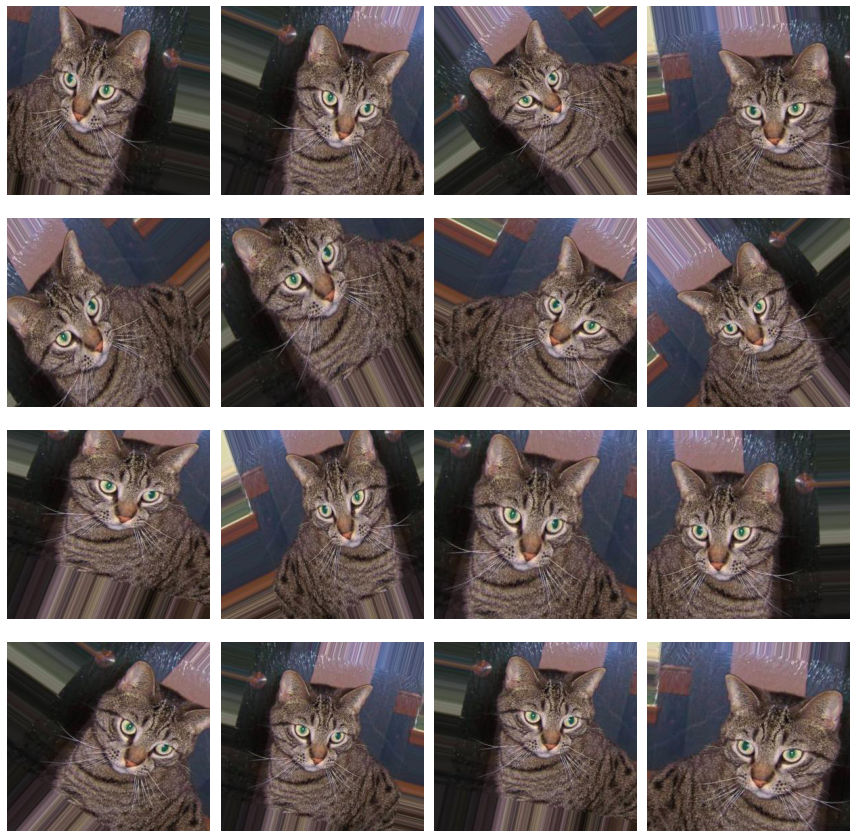

In [13]:
plt.figure(figsize=(12,12))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    image = load_img(os.path.join("preview",samples[i]))
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()
plt.show()

### 使用增强数据再次优化模型

In [14]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
         train_dir,  # this is the target directory
        target_size=(160, 160),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(160, 160),
        batch_size=batch_size,
        class_mode='binary')

Found 1800 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [15]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
model = tf.keras.Sequential([
      base_model,
      keras.layers.GlobalAveragePooling2D(),
      keras.layers.Dense(1, activation='sigmoid')
])

In [17]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs = 1
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              shuffle=True,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


 1/14 [=>............................] - ETA: 1:33 - loss: 0.8751 - accuracy: 0.3750

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

## Fine tuning(微调优化)

在我们的特征提取实验中，我们仅在MobileNet V2基本模型之上训练了几层。训练过程中未更新预训练网络的权重。进一步提高性能的一种方法是，在训练顶级分类器的同时，“微调”预训练模型顶层的权重。训练过程将迫使权重从通用特征图调整为专门与我们的数据集相关联的特征。 

注意：只有在您将训练后的模型设置为不可训练的顶级分类器之后，才能尝试进行此操作。如果您在预训练模型的顶部添加随机初始化的分类器，并尝试共同训练所有图层，则梯度更新的幅度将太大（由于分类器的随机权重），因此预训练模型将只是忘记它学到的一切。 此外，对预训练模型的顶层而不是预训练模型的所有层进行微调的原因如下：在ConvNet中，高层越高，则其越针对。 ConvNet的前几层学习了非常简单和通用的特征，这些特征普遍适用于几乎所有类型的图像。但是，随着您的前进，这些功能将越来越多地针对训练模型的数据集。微调的目的是使这些专用特征适应新数据集的需要。

### 解冻部分高层，尝试调优


逐步解冻基础模型，重新编译并训练模型。

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### 编译模型

重新编译模型，使用更小的学习率。

In [ ]:

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
len(model.trainable_variables)

### 继续训练模型

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [ ]:
history_fine = model.fit_generator(train_generator,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs=1,
                                   workers=4,
                                   validation_data=validation_generator,
                                   validation_steps=validation_steps)

### 学习曲线分析

当微调MobileNet V2基本模型的最后几层以及其顶部的分类器时，让我们看一下训练和验证准确性/损失的学习曲线。请注意，验证损失比训练损失高得多，这意味着可能有些过拟合。

**注意**：训练数据集非常小，并且与MobileNet V2训练时使用的原始数据集相似，因此微调可能会导致过拟合。


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> 参考fine-tune结果

![](./img/fine-tune-scores.png)

## 模型部署

在这一节中，我们一起来学习下如何将模型部署成web服务。

```bash
source /anaconda/envs/py35/bin/activate

source activate py35

```

# 总结

总结一下，这是我们在本教程中介绍的有关如何使用预训练模型来提高准确性的迁移学习的内容：

* 使用预先训练的模型进行“特征提取”-在处理小型数据集时，通常会利用在相同域中的大型数据集上训练的模型所学习的特征。这是通过实例化预训练模型并在顶部添加完全连接的分类器来完成的。预先训练的模型是“冻结的”，并且在训练期间仅更新分类器的权重。 在这种情况下，卷积基础提取与每个图像关联的所有特征，然后我们训练一个分类器，该分类器根据这些特征集确定其属于哪个类。 
* **微调**一种预先训练的模型-为了进一步提高性能，可能需要通过微调将预先训练的模型的顶层重新用于新的数据集。 在这种情况下，我们调整权重，以便我们学习针对数据集的高度指定的高级特征。仅当训练数据集很大并且非常类似于训练前模型所训练的原始数据集时，这才有意义。
